In [2]:

import numpy as np
import random
import matplotlib.pyplot as plt

## torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset , random_split




DATASET_PATH = "./data"
random.seed(42)
#Device
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# print("Device:", device)


In [3]:
from files.models import *

#### Data Preparation : Partionning & preprocesing

## **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.


In [4]:
# Transform to normalized Tensors in the range [0,1]

transform = T.Compose([T.Pad(2) #to cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).
                       , T.ToTensor(), T.Normalize((0.5,), (0.5,))])

In [5]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=transform)
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=transform)

In [6]:
MNIST_train_dataset, MNIST_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

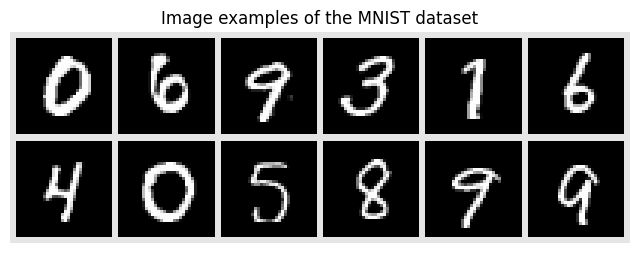

In [7]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [8]:
# use DataLoader to keep applied transformation when download the data..

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)
# help(MNIST_train_loader)
#check stats :
data_iter = iter(MNIST_train_loader)
images, labels = next(data_iter)

mean = images.mean()
std = images.std()
min_val = images.min()
max_val = images.max()

print(f'Batch Mean: {mean.item()}')
print(f'Batch Std: {std.item()}')
print(f'Batch Min: {min_val.item()}')
print(f'Batch Max: {max_val.item()}')

Batch Mean: -0.7938809394836426
Batch Std: 0.5580133199691772
Batch Min: -1.0
Batch Max: 1.0


In [9]:
train_images, train_labels = next(iter(MNIST_train_loader))
print(train_images.shape) 
print(train_labels.shape) 

torch.Size([64, 1, 32, 32])
torch.Size([64])


#### Baseline Model Setup : extent with limited labeled data

In [10]:
indices = np.random.permutation(len(MNIST_train_dataset))[:100]

train_100= Subset(MNIST_train_dataset, indices)
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)

In [11]:
image, label = train_100[0]  
image.shape, label


(torch.Size([1, 32, 32]), 7)

In [15]:
model = Basic_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [16]:
num_epochs = 10
model.train() 
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_100_loader:
        optimizer.zero_grad()          
        outputs = model(images)        
        loss = criterion(outputs, labels) 
        loss.backward()                
        optimizer.step()              
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_100_loader):.4f}")

Epoch [1/10], Loss: 2.6612
Epoch [2/10], Loss: 1.9198
Epoch [3/10], Loss: 1.3252
Epoch [4/10], Loss: 1.1027
Epoch [5/10], Loss: 0.8054
Epoch [6/10], Loss: 0.6405
Epoch [7/10], Loss: 0.5163
Epoch [8/10], Loss: 0.3943
Epoch [9/10], Loss: 0.3203
Epoch [10/10], Loss: 0.2713


In [22]:
model.eval()  
correct = 0
total = 0

with torch.no_grad():
    for images, labels in MNIST_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set (10K): {100 * correct / total:.2f}%")

Accuracy on the test set (10K): 77.74%


MoCo was implemented on RGB ImageNet data with and ResNet encoder 

* adapting the input layer to handle 28x28 grayscale images (instead of the 224x224 RGB images typically used with ImageNet

In [33]:
transform_MoCo = T.Compose([
    T.Resize((32, 32)),  
    T.Grayscale(3),      # dupe channels to simulate RGB
    T.RandomApply([
        T.RandomRotation(10),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

train_MoCo = MNIST(root=DATASET_PATH, train=True, download=True, transform=transform_MoCo)
test_MoCo= MNIST(root=DATASET_PATH, train= False, download=True, transform=transform_MoCo)


* modify MoCo loader to handle our data
* configuration (explore light encoder beside resnet(mnist is too simple than imageNet))